In [15]:
# Importing Dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sqlite3
import numpy as np
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.callbacks import Callback
import keras_tuner as kt

In [16]:
# Importing data
conn = sqlite3.connect('data.db')
churn_data = pd.read_sql_query("SELECT * FROM data", conn)
conn.close()
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [17]:
# Dropping non-essential columns in reference to churn potential
churn_data = churn_data.drop(["RowNumber", "CustomerId", "Surname", "Geography"], axis=1)
churn_data

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,619,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,608,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,502,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,699,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,850,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,Male,39,5,0.00,2,1,0,96270.64,0,0,1,DIAMOND,300
9996,516,Male,35,10,57369.61,1,1,1,101699.77,0,0,5,PLATINUM,771
9997,709,Female,36,7,0.00,1,0,1,42085.58,1,1,3,SILVER,564
9998,772,Male,42,3,75075.31,2,1,0,92888.52,1,1,2,GOLD,339


In [18]:
# Designating bins to group credit scores
bins = [299, 579, 669, 739, 799, 850]
churn_data["CreditScore"] = pd.cut(churn_data["CreditScore"], bins=bins, labels=["300-579", "580-669", "670-739", "740-799", "800-850"])

# Checking if binning was successful
churn_data["CreditScore"].value_counts()

CreditScore
580-669    3331
670-739    2428
300-579    2362
740-799    1224
800-850     655
Name: count, dtype: int64

In [19]:
bins = [0, 25000, 50000, 75000, 100000, 125000, 900000]
churn_data["EstimatedSalary"] = pd.cut(churn_data["EstimatedSalary"], bins=bins, labels=["0-25k", "25k-50k", "50k-75k", "75k-100k", "100k-125k", "125k+"])
churn_data["EstimatedSalary"].value_counts()

EstimatedSalary
125k+        3734
100k-125k    1276
50k-75k      1269
75k-100k     1268
25k-50k      1236
0-25k        1217
Name: count, dtype: int64

In [20]:
bins = [0, 25000, 50000, 75000, 100000, 125000, 900000]
churn_data["Balance"] = pd.cut(churn_data["Balance"], bins=bins, labels=["0-25k", "25k-50k", "50k-75k", "75k-100k", "100k-125k", "125k+"])
churn_data["Balance"].value_counts()

Balance
125k+        2731
100k-125k    2068
75k-100k     1160
50k-75k       349
25k-50k        69
0-25k           6
Name: count, dtype: int64

In [21]:
bins = [0, 20, 40, 60, 80, 200]
churn_data["Age"] = pd.cut(churn_data["Age"], bins=bins, labels=["0-20", "20-40", "40-60", "60-80", "80+"])
churn_data["Age"].value_counts()

Age
20-40    6330
40-60    3117
60-80     452
0-20       89
80+        12
Name: count, dtype: int64

In [22]:
# Converting categorical data to numeric with "pd.get_dummies"
numerics = pd.get_dummies(churn_data)
numerics

,Tenure,NumOfProducts,HasCrCard,IsActiveMember,Exited,Complain,Satisfaction Score,Point Earned,CreditScore_300-579,CreditScore_580-669,...,EstimatedSalary_0-25k,EstimatedSalary_25k-50k,EstimatedSalary_50k-75k,EstimatedSalary_75k-100k,EstimatedSalary_100k-125k,EstimatedSalary_125k+,Card Type_DIAMOND,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER
0,2,1,1,1,1,1,2,464,False,True,...,False,False,False,False,True,False,True,False,False,False
1,1,1,0,1,0,1,3,456,False,True,...,False,False,False,False,True,False,True,False,False,False
2,8,3,1,0,1,1,3,377,True,False,...,False,False,False,False,True,False,True,False,False,False
3,1,2,0,0,0,0,5,350,False,False,...,False,False,False,True,False,False,False,True,False,False
4,2,1,1,1,0,0,5,425,False,False,...,False,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,5,2,1,0,0,0,1,300,False,False,...,False,False,False,True,False,False,True,False,False,False
9996,10,1,1,1,0,0,5,771,True,False,...,False,False,False,False,True,False,False,False,True,False
9997,7,1,0,1,1,1,3,564,False,False,...,False,True,False,False,False,False,False,False,False,True
9998,3,2,1,0,1,1,2,339,False,False,...,False,False,False,True,False,False,False,True,False,False


In [23]:
# Splitting preprocessed data into featured and target arrays
y = numerics["Exited"].values
x = numerics.drop("Exited", axis = 1).values

# Getting the training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [24]:
# Creating StandardScaler instances
scaler = StandardScaler()

# Fitting StandardScaler
x_scaler = scaler.fit(x_train)

# Scaling data
x_train_scaled = x_scaler.transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

In [25]:
#Determine number of input features
input_features = x_train_scaled.shape[1]
input_features

35

In [26]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value= 90,
        step=5), activation=activation, input_dim=input_features))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 5)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=30,
            step=5),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [ ]:
# Define a custom callback to log accuracy after each trial
class AccuracyLogger(Callback):
    def __init__(self):
        super(AccuracyLogger, self).__init__()
        self.accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        self.accuracies.append(logs.get('val_accuracy'))

In [27]:
# Import the kerastuner library
# tuner = kt.Hyperband(
#     create_model,
#     objective="val_accuracy",
#     max_epochs=20,
#     hyperband_iterations=2,
#     project_name="KerasTuner_Churn"
# )

# Initialize Keras Tuner
tuner = RandomSearch(
    create_model,  # Define your model builder function here
    objective='val_accuracy',
    max_trials=10,  # Specify the number of trials
    project_name='KerasTuner_Churn')

C:\Users\domin\anaconda3\envs\dev\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Trial 60 Complete [00h 00m 12s]
val_accuracy: 0.9983999729156494

Best val_accuracy So Far: 0.9983999729156494
Total elapsed time: 00h 06m 09s


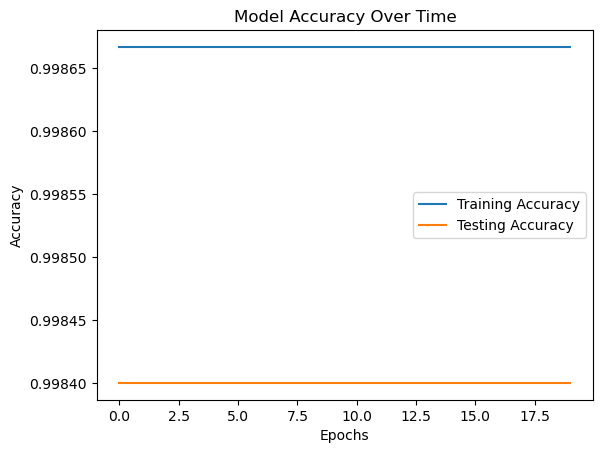

In [28]:
# Run the kerastuner search for best hyperparameters
# tuner.search(x_train_scaled, y_train, epochs=20, validation_data=(x_test_scaled, y_test))

# train_accuracies = []
# test_accuracies = []
# epochs = 20

# for e in range(epochs):
#     model = tuner.get_best_models(num_models=1)[0]
    
#     # Train the model
#     history = model.fit(x_train_scaled, y_train, epochs=1, validation_data=(x_test_scaled, y_test), verbose=0)
    
#     # Evaluate model on training data
#     train_loss, train_accuracy = model.evaluate(x_train_scaled, y_train, verbose=0)
#     train_accuracies.append(train_accuracy)
    
#     # Evaluate model on testing data
#     test_loss, test_accuracy = model.evaluate(x_test_scaled, y_test, verbose=0)
#     test_accuracies.append(test_accuracy)

# # Plotting
# plt.plot(range(epochs), train_accuracies, label='Training Accuracy')
# plt.plot(range(epochs), test_accuracies, label='Testing Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Model Accuracy Over Time')
# plt.legend()
# plt.show()




In [29]:
# Top 3 model hyperparameters 
top_hyper = tuner.get_best_hyperparameters(3)
for param in top_hyper:
    print(param.values)

{'activation': 'tanh', 'first_units': 51, 'num_layers': 2, 'units_0': 6, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0, 'units_1': 1}
{'activation': 'tanh', 'first_units': 41, 'num_layers': 4, 'units_0': 6, 'units_1': 11, 'units_2': 11, 'units_3': 11, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
{'activation': 'relu', 'first_units': 21, 'num_layers': 2, 'units_0': 6, 'units_1': 21, 'units_2': 21, 'units_3': 6, 'tuner/epochs': 3, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}


In [30]:
# Top 3 models
top_model = tuner.get_best_models(3)
for model in top_model:
    model_loss, model_accuracy = model.evaluate(x_test_scaled,y_test,verbose=2)
    print(f'Loss: {model_loss}, Accuracy: {model_accuracy}')

79/79 - 0s - 5ms/step - accuracy: 0.9984 - loss: 0.3380
Loss: 0.33800753951072693, Accuracy: 0.9983999729156494
79/79 - 0s - 5ms/step - accuracy: 0.9984 - loss: 0.0264
Loss: 0.026439178735017776, Accuracy: 0.9983999729156494
79/79 - 0s - 4ms/step - accuracy: 0.9984 - loss: 0.0113
Loss: 0.011343728750944138, Accuracy: 0.9983999729156494


In [31]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters()[0]
best_hyper.values

{'activation': 'tanh',
 'first_units': 51,
 'num_layers': 2,
 'units_0': 6,
 'tuner/epochs': 3,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0,
 'units_1': 1}

In [32]:
# Evaluate best model against full test data
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(x_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

79/79 - 0s - 4ms/step - accuracy: 0.9984 - loss: 0.3380
Loss: 0.33800753951072693, Accuracy: 0.9983999729156494
